## Assignment - Building Multiple Linear regression model for Prediction of demand for shared bikes

## What are are going to do
* Understanding the dataset and given features
* Drop unncessory columns which are of no use and can not help in prediction
* Find out the categorical data and convert it into dummy variables
* Split the data into train and test (usually we split the data into 70 / 30 ratio)
* Now, we will work with train data, one more than we need to see the scaling, we have to scale the data using MinMaxScaler (it's usaully best to use MinMax Scaler, it compress the entire data between 0 and 1)
* Now, we can describe train data and observe, (Max values should not be greater than 1 for any column), you can also try to observer the data using correlation matrix (heatmap / subplots etc)
* At this moment, we can split the data between X and y train, basically for model training, we have to use 'cnt' as our target variable.
* Now, we can perform 'Recursive Feature Elimination' to choose best feature for model training. As starting point, we will start with (50%) feature selection
* Now, we will observe the Columns - rfe support - rfe ranking, we normally eliminate 'False' rfe support
* Choose columns which has rfe support value as 'True'
* Now, at this point we have at least good features with us, we can traing the model using stats model api and we might need to eliminate couple of more based on p-value and VIF ranking
  * High p-value and low VIF - remove first
  * Now observe - High VIF - low p-value - remove next
  * Continue observeation until you have low p-value and low VIF (p-value < 0.5 and VIF < 5)
* Once we have stable model after above analysis, we can proceed with residual analysis
* Now, we can make prediction based on our test data, we need to scale our data - this time use only transform not fit (fit only used when training our model)
* Finally we can predict the data and see the plot

### 1. Import the important libraries and ignore warnings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

### 2. Import the dataset and understand the features

In [27]:
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [17]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


cnt           1.000000
registered    0.945411
casual        0.672123
atemp         0.630685
temp          0.627044
hum          -0.098543
windspeed    -0.235132
Name: cnt, dtype: float64


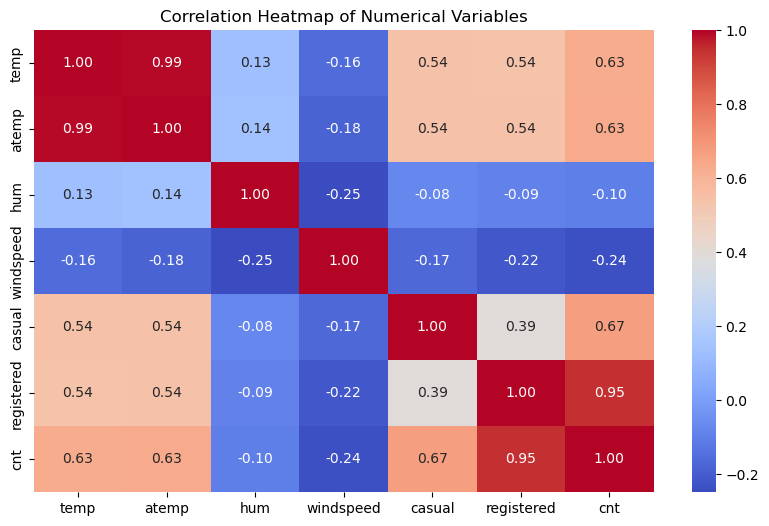

In [39]:
# Selecting numerical columns
numerical_cols = ["temp", "atemp", "hum", "windspeed", "casual", "registered", "cnt"]

# Compute correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Display correlation with target variable (cnt)
print(correlation_matrix["cnt"].sort_values(ascending=False))

# Visualizing correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()

### 3. Drop the features which are not related and not helpful in model building

In [41]:
# Removing casual and registered from the data, since they are part of cnt already
df = df.drop(columns=['instant', 'dteday', 'casual', 'registered'], axis=1)

### 4. Find out the categorical data and convert it into dummy variables

In [43]:
df = pd.get_dummies(df, columns=['season', 'mnth', 'weekday', 'weathersit'], dtype=int, drop_first=True)

In [45]:
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,0,0,0,0,1,0,0,0,0,0


### 5. Split the data into train and test (usually we split the data into 70 / 30 ratio)

In [47]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=100)

### 6. Now, we will work with train data, one more than we need to see the scaling, we have to scale the data using MinMaxScaler (it's usaully best to use MinMax Scaler, it compress the entire data between 0 and 1)

In [49]:
# 1. Instantiate an Object
scaler = MinMaxScaler()

# 2. Scale the values
df_train[['temp', 'atemp', 'hum', 'windspeed', 'cnt']] = scaler.fit_transform(df_train[['temp', 'atemp', 'hum', 'windspeed', 'cnt']])

df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,1,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,0,0,...,0,0,0,0,0,0,0,1,1,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,0,0,...,0,1,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,1,0,...,0,0,0,0,0,0,0,1,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,1,0,...,0,0,0,0,0,0,1,0,1,0


### 7. Now, we can describe train data and observe, (Max values should not be greater than 1 for any column), you can also try to observer the data using correlation matrix (heatmap / subplots etc)

In [51]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.247059,0.262745,...,0.086275,0.084314,0.150980,0.131373,0.158824,0.133333,0.127451,0.154902,0.345098,0.029412
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.431725,0.440557,...,0.281045,0.278131,0.358381,0.338139,0.365870,0.340268,0.333805,0.362166,0.475867,0.169124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 8. At this moment, we can split the data between X and y train, basically for model training, we have to use 'cnt' as our target variable.

In [53]:
y_train = df_train.pop('cnt')
X_train = df_train

In [36]:
X_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_2', 'season_3', 'season_4', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weathersit_2', 'weathersit_3'],
      dtype='object')

### 9. Now, we can perform 'Recursive Feature Elimination' to choose best feature for model training. As starting point, we will start with (50%) feature selection

In [55]:
# running RFE with the output number of the variables equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_2', True, 1),
 ('season_3', True, 1),
 ('season_4', True, 1),
 ('mnth_2', False, 7),
 ('mnth_3', False, 2),
 ('mnth_4', False, 4),
 ('mnth_5', False, 3),
 ('mnth_6', False, 5),
 ('mnth_7', False, 8),
 ('mnth_8', True, 1),
 ('mnth_9', True, 1),
 ('mnth_10', True, 1),
 ('mnth_11', False, 9),
 ('mnth_12', False, 10),
 ('weekday_1', False, 11),
 ('weekday_2', False, 12),
 ('weekday_3', False, 14),
 ('weekday_4', False, 15),
 ('weekday_5', False, 13),
 ('weekday_6', True, 1),
 ('weathersit_2', True, 1),
 ('weathersit_3', True, 1)]

### 10. Now, we will observe the Columns - rfe support - rfe ranking, we normally eliminate 'False' rfe support
* Choose columns which has rfe support value as 'True'

In [57]:
selected_features = X_train.columns[rfe.support_]
selected_features

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'mnth_8', 'mnth_9', 'mnth_10', 'weekday_6',
       'weathersit_2', 'weathersit_3'],
      dtype='object')

In [59]:
X_train.columns[~rfe.support_]

Index(['atemp', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7',
       'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5'],
      dtype='object')

### 11. Now, at this point we have at least good features with us, we can traing the model using stats model api and we might need to eliminate couple of more based on p-value and VIF ranking
  * High p-value and low VIF - remove first
  * Now observe - High VIF - low p-value - remove next
  * Continue observeation until you have low p-value and low VIF (p-value < 0.5 and VIF < 5)

In [61]:
# Create dataset with selected features with RFE selected variables
X_train_rfe = X_train[selected_features]

In [63]:
# Add constant to the dataframe

X_train_sm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train, X_train_sm).fit() # running the linear model

# Let's see the summary fo out linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     183.9
Date:                Mon, 03 Mar 2025   Prob (F-statistic):          5.17e-191
Time:                        22:43:24   Log-Likelihood:                 519.44
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1952      0.029      6.790   

In [65]:
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
3,temp,24.07
4,hum,17.44
7,season_3,8.19
2,workingday,5.05
5,windspeed,3.88
6,season_2,3.46
8,season_4,2.85
13,weathersit_2,2.15
0,yr,2.04
12,weekday_6,1.91


In [67]:
# Based on our understanding, we have to first eliminate features with high p-value
X_train_filter = X_train_rfe.drop(['season_3'], axis=1)

### Perform Analysis again and observe the p-value and VIF

In [69]:
X_train_sm = sm.add_constant(X_train_filter)
lm = sm.OLS(y_train, X_train_sm).fit() # running the linear model
# Let's see the summary fo out linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.6
Date:                Mon, 03 Mar 2025   Prob (F-statistic):          8.70e-192
Time:                        22:43:31   Log-Likelihood:                 518.52
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     495   BIC:                            -943.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1948      0.029      6.769   

In [71]:
vif = pd.DataFrame()
X = X_train_filter
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
4,hum,16.57
3,temp,10.01
2,workingday,5.05
5,windspeed,3.83
7,season_4,2.25
12,weathersit_2,2.14
0,yr,2.03
11,weekday_6,1.90
6,season_2,1.84
10,mnth_10,1.61


In [73]:
# Now as you can see, we have low p-value but some features have high VIF value, greater than 5, we have to eliminate them

X_train_filter_1 = X_train_filter.drop(['hum', 'temp'], axis=1)

### Perform Analysis again and observe p-value and VIF

In [75]:
X_train_sm = sm.add_constant(X_train_filter_1)
lm = sm.OLS(y_train, X_train_sm).fit() # running the linear model
# Let's see the summary fo out linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     83.32
Date:                Mon, 03 Mar 2025   Prob (F-statistic):          1.16e-110
Time:                        22:43:37   Log-Likelihood:                 320.04
No. Observations:                 510   AIC:                            -614.1
Df Residuals:                     497   BIC:                            -559.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3642      0.022     16.698   

In [77]:
# Calculate VIFs

vif = pd.DataFrame()
X = X_train_filter_1
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
2,workingday,3.53
3,windspeed,3.41
5,season_4,2.00
0,yr,1.91
4,season_2,1.61
9,weekday_6,1.61
8,mnth_10,1.56
10,weathersit_2,1.54
6,mnth_8,1.23
7,mnth_9,1.16


### 12. Once we have stable model after above analysis, we can proceed with residual analysis

In [79]:
# Make the prediction with trained model

y_train_count = lm.predict(X_train_sm)

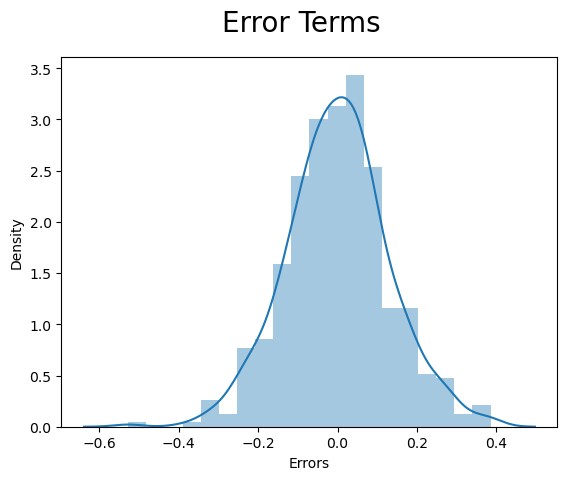

In [81]:
fig = plt.figure()
sns.distplot((y_train - y_train_count), bins = 20)
fig.suptitle('Error Terms', fontsize=20)
plt.xlabel('Errors', fontsize=10)
plt.show()

### 13. Now, we can make prediction based on our test data, we need to scale our data - this time use only transform not fit (fit only used when training our model)

In [83]:
# Transform the test data / scale
df_test[['temp', 'atemp', 'hum', 'windspeed', 'cnt']] = scaler.transform(df_test[['temp', 'atemp', 'hum', 'windspeed', 'cnt']])

In [85]:
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,1,...,0,0,1,0,0,0,0,0,1,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,1,0,...,0,0,0,0,1,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,0,0,0,0,0,1,0,0,1,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,1,...,0,0,0,0,1,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,1,0,...,0,0,0,0,0,1,0,0,0,0


### 14. Finally we can predict the data and see the plot

In [87]:
y_test = df_test.pop('cnt')
X_test = df_test

In [89]:
# Now let's use our model to make predictions
X_train_final = X_train_sm.drop(['const'], axis=1)

# creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_final.columns]

# Adding a constant variable
X_test_new = sm.add_constant(X_test_new)

In [91]:
# Making prediction
y_pred = lm.predict(X_test_new)

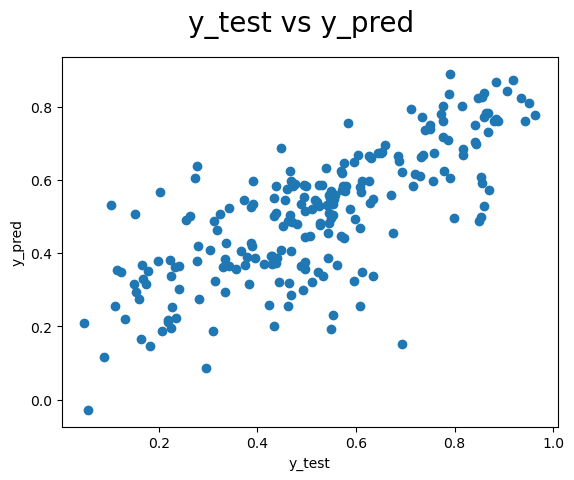

In [93]:
# plot
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=10)
plt.ylabel('y_pred', fontsize=10)
plt.show()